In [1]:
from utils.rw_processed_data import load_processed_data

In [2]:
data = load_processed_data(folder_name='OMNI', name='full_data')

In [3]:
data.drop(data[data['Dst_index'] == 999.9].index, inplace=True)
data.drop(data[data['B_scalar'] == 999.9].index, inplace=True)
data.drop(data[data['Bz_GSM'] == 999.9].index, inplace=True)
data.drop(data[data['Dst_index'] == 999.9].index, inplace=True)

In [4]:
filter_data = data.copy()

In [5]:
def class_count(df):
    count = {"fraca": 0, "moderada": 0, "intensa": 0, "super_intensa": 0}
    for i in range(1, len(df)):
        count[df['classification'].iloc[i]]+=1
    print(count)

class_count(data)


{'fraca': 2241, 'moderada': 1105, 'intensa': 216, 'super_intensa': 15}


In [6]:
from sklearn.calibration import LabelEncoder

le = LabelEncoder()

filter_data['classification'] = le.fit_transform(filter_data['classification'])

In [10]:
X = filter_data[['Dst_index', 'Bz_GSM']].copy()
y = filter_data['classification']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=4))]
)

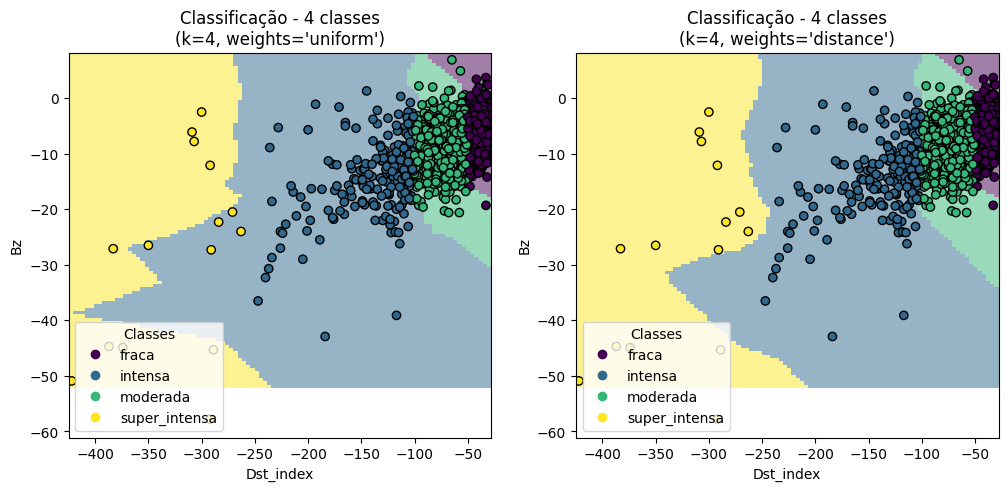

In [56]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="Dst_index",
        ylabel="Bz",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        ["fraca", "intensa", "moderada", "super_intensa"],
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"Classificação - 4 classes\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

In [57]:
y_predict = clf.predict(X_test)

In [63]:
import numpy as np
# indetificar outliers
filter_data.filter(items=(y_test != y_predict).index[np.where(y_test != y_predict)[0]], axis=0).sort_values(by='date')

,date,Dst_index,Kp_index,B_scalar,Bz_GSM,classification
19649,1990-08-14,-57.0,43.0,15.4,4.9,2
16305,2002-04-20,-98.0,73.0,30.4,-18.1,2
9357,2005-01-17,-50.0,40.0,5.8,-2.3,0
17708,2014-09-13,-65.0,40.0,31.1,6.9,2
13471,2015-08-15,-103.0,63.0,13.4,-10.8,1
13677,2017-05-06,-33.0,57.0,22.8,-19.3,0


In [59]:
from sklearn.metrics import confusion_matrix

matrix_data = confusion_matrix(y_test, y_predict)

In [60]:
import seaborn as sns

def plot_confusion_matrix(matrix_data):  
    fig, ax = plt.subplots()
    sns.heatmap(
        matrix_data, 
        annot=True, 
        ax=ax, 
        fmt='d', 
        cmap='Reds',
        cbar=False,
        xticklabels=le.classes_,
        yticklabels=le.classes_
    )

    ax.set_title("Matriz de Confusão", fontsize=16)
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    plt.tight_layout()

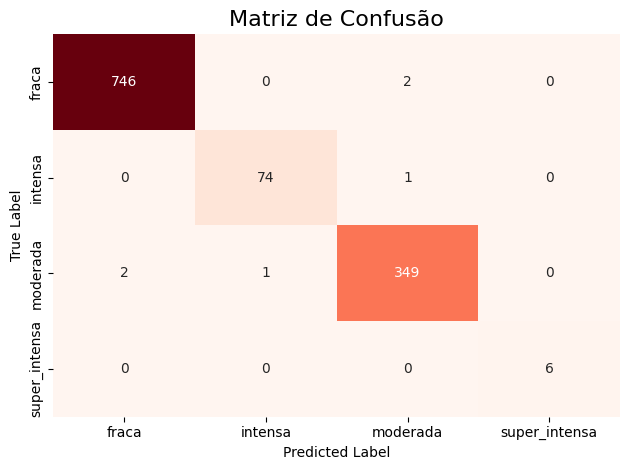

In [61]:
plot_confusion_matrix(matrix_data)

In [62]:
from sklearn.metrics import classification_report
report = classification_report(y_true=y_test, y_pred=y_predict)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       748
           1       0.99      0.99      0.99        75
           2       0.99      0.99      0.99       352
           3       1.00      1.00      1.00         6

    accuracy                           0.99      1181
   macro avg       0.99      0.99      0.99      1181
weighted avg       0.99      0.99      0.99      1181

